In [1]:
import sys, os

sys.path.append('/Users/ajc/codes/simulator/debug/ats-mesh/tools/meshing_ats/meshing_ats')
import meshing_ats

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib

In [3]:
print(meshing_ats.__file__)
xl =pd.ExcelFile('Topo_Profiles_Barrow.xlsx')

/Users/ajc/codes/simulator/debug/ats-mesh/tools/meshing_ats/meshing_ats/meshing_ats.py


In [4]:
xl.sheet_names
print (xl.sheet_names)
data = xl.parse(sheet_name='Transect B, Area C')
keys = data.keys()
slice_at_right = False

['Transect A, Polygon near ERT', 'Transect B, Polygon near ERT', 'Transect Area B', 'Transect A, Area C', 'Transect B, Area C', 'Repeat ERT Transect']


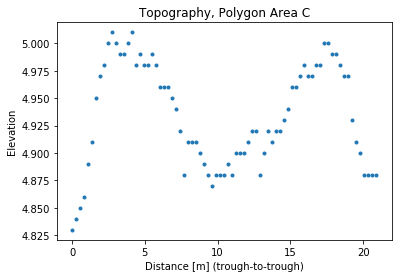

In [5]:
plt.plot(data['Distance_m'], data['Z'],'.')
plt.ylabel('Elevation')
plt.title('Topography, Polygon Area C')
plt.xlabel('Distance [m] (trough-to-trough)')
plt.show()

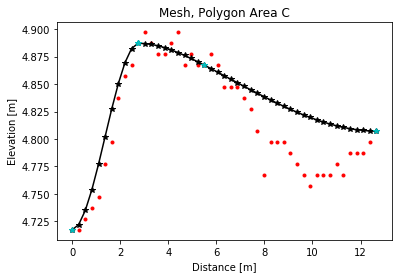

In [11]:
# smooth the topographic data : February 13 and trough cell inward oriented
length = len(data['Distance_m'])
x = []
z = []

if (slice_at_right):
    x = np.array(data['Distance_m'][length/2:])
    z = np.array(data['Z'][length/2:])
else:
    x = np.array(data['Distance_m'][:46])
    z = np.array(data['Z'][:46])

z = [z1 - 0.1127955 for z1 in z] # match the trough's elevation with the "trough elevation" from water-table data 
A1 = []
A1 = np.insert(x, 0, -x[1])
x = np.array([a + x[1] for a in A1])
z = np.insert(z,0, z[0]+.0000)

lower_it = 0.0
lower_center = 0.0
if lower_it >= 0 and lower_center <= 0: #revert sign to execute
    x1 = [x[0], x[10]]
    z1 = [z[0], z[10]-lower_it]
    x2 = [x[10], x[20], x[-1]]
    z2 = [z[10]-lower_it, z[20]-lower_it, z[-1]]
    cs1 = scipy.interpolate.CubicSpline(x1,z1, bc_type='clamped')
    cs2 = scipy.interpolate.CubicSpline(x2,z2, bc_type='clamped')

z_smooth = np.concatenate((cs1(x[:11]), cs2(x[11:])))
z_smooth = np.array([round(s,4) for s in z_smooth])

plt.plot(x, z, '.', color='r')
plt.plot(x, z_smooth, '-*', color = 'k')
plt.plot(x1,z1,'*', color='c')
plt.plot(x2,z2,'*', color='c')
#plt.plot(x3,z3,'*', color='c')
#plt.plot(x4,z4,'.', color='g')
plt.ylabel('Elevation [m]')
plt.xlabel('Distance [m]')
plt.title('Mesh, Polygon Area C')
plt.show()

In [ ]:
import math
def Distance(x,y):
    d = np.zeros(len(x))
    for i in range(len(x)):
        d[i] = math.hypot(x[-1] - x[i], y[-1] - y[i])
    return d

In [ ]:
#Vladimir data
site_area = 'C'
if site_area == 'C': 
    print (site_area)
    zv = np.array([5.099, 5.169, 5.321, 4.968])
    zv =zv[::-1]
    northing = [7910344.103,7910341.163,7910337.608, 7910335.845] #original
    easting = [585907.153,585907.605,585908.893,585909.606]
    distC = Distance(northing,easting)
    distC = distC[::-1]
    print (distC, zv)
    numx1 = int((distC[1] - distC[0]) / 0.17)
    numx2 = int((distC[-1] - distC[1]) / 0.23)
    print (numx1, numx2)
    xnew1 = np.linspace(distC[0],distC[1],numx1)
    xnew2 = np.linspace(distC[1],distC[-1],numx2)
    cs1 = scipy.interpolate.CubicSpline(distC[:2],zv[:2], bc_type='clamped')
    cs2 = scipy.interpolate.CubicSpline(distC[1:],zv[1:], bc_type='clamped')
    
print ('left', xnew1[1] - xnew1[0], numx1)
print ('right', xnew2[-1] - xnew2[-2], numx2)
    
plt.plot(xnew1, cs1(xnew1), '.-', color= 'r', label = 'fitted curve')
plt.plot(xnew2, cs2(xnew2), '.-', color= 'r')
plt.plot(distC, zv, '*', color= 'k', label='measured data')

plt.show()

if 'D' in site_area:
    xnew = xnew1
    zv = cs1(xnew1)
else:
    xnew = np.concatenate((xnew1,xnew2[1:]))
    zv = np.concatenate((cs1(xnew1), cs2(xnew2[1:])))
 
print ('---------------------------------------------')

assert len(zv) == len(xnew)


#trough
observe = 'center'
xloc = 0
mid_pt = (zv[0] + zv[1])/2.

depths_t = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.5, 0.6,0.7,0.8, 1.0, 1.25, 1.50]
depths_r = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.5, 0.6,0.7,0.8, 1.0, 1.25, 1.50]
depths_c = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 00.35, 0.4, 0.42, 0.5, 0.6,0.7,0.8, 1.0, 1.25, 1.50]
if observe == 'trough':
    z_location = [zv[1] - v for v in depths_t] #taking z at zv[1] to make sure the observed point lie within above cell
    xloc = np.where(zv == zv[0])
    xloc = xnew[xloc]
elif observe == 'rim':
    if 'B' in site_area: # max in polygon B is the center.. so we need to get the right location for rim
        z_location = [zv[numx1] - v for v in depths_r]
        print ('B')
    else:
        z_location = [max(zv) - v for v in depths_r]
        print ('Not B')
    xloc = np.where(zv == max(zv))
elif observe == 'center':
    if 'B' in site_area:
        z_location = [zv[-1] - v for v in depths_c]
    else:
        z_location = [zv[-2] - v for v in depths_c]
    
zv = np.round(zv, 5)
xnew = np.round(xnew,5)
print (observe, np.round(z_location,5), max(zv))
print (zv[-2], zv[-1])

plt.xlabel('Distance [m]')
plt.ylabel('Elevation [m]')
plt.title('Polygon Area B')
plt.legend()


In [ ]:
z_smooth = zv
x = xnew
print (x, z_smooth)
print (len(x), len(z_smooth))
print ('Seepage face high at the center ', max(z_smooth - z_smooth[0]))

In [ ]:
importlib.reload(meshing_ats)

if site_area == 'A':
    arclen = 16
elif site_area == 'B':
    arclen = 6
elif site_area == 'C':
    arclen = 10
elif site_area == 'D':
    arclen = 10
m2 = meshing_ats.Mesh2D.from_Transect_MakePieWedge(x,z_smooth, arclen, curved=False)

print (site_area, arclen)
m2.plot()

In [ ]:
x0,x1 = x[0], x[6]
z_upper = z_smooth[0] - 0.5
z_lower = z_upper - 3.0
z_lower = 1.40296789
print (z_smooth[0], z_upper, z_lower)
from numpy import ones,vstack
from numpy.linalg import lstsq
P = (x1,z_upper)
Q = (x0, z_lower)

P =(x[6],0)
xx = np.linspace(0,x[6],7)
Q = (z_upper,z_lower)

slope = (z_upper-z_lower)/(x[6]-0)
y = z_upper + slope*(xx-x[6])
#print (m)
plt.plot(xx,y,'.')
print (y)#,x[6],x)

In [ ]:

Depth = np.zeros((m2.num_cells(),60))
DisX = np.zeros((m2.num_cells()+1,60))
for i in range(60):
    DisX[:,i] = x
#print (DisX[6,:])
z = 0
dz=0.02
for i in range(m2.num_cells()):
    #z1 = z_smooth[i]
    for j in range(26):
        z1 = z_smooth[i] - dz*j
        Depth[i,j] = z1
print ('Upper mineral ', Depth[0],Depth[0][25])

dz=0.02
for i in range(m2.num_cells()):
    #z1 = z + z_smooth[i]
    z = 0
    dz = .02
    for j in range(26,26+34):
        dz *= 1.075
        z = z + dz
        #print (z)
        #z1 = z_smooth[i] - dz
        Depth[i,j] = Depth[i,25] - z
        #print (Depth[i,j])
    #z = z1
print ('Ice rich new ', z, Depth[0])
l = np.where(Depth[0]>0)[0]
l = l[-1]
#print ('LL: ',l)
X = 1.40296789

print ('Depth shape ', Depth.shape)
print (Depth[:,0])#,Depth[2,:])
IRZ_layer=-2000*np.ones((m2.num_cells(), l-25))

print (IRZ_layer.shape)


for i in range(m2.num_cells()):
    irz = []
    #break
    y1 = z_upper + slope*(x[i]-x[6])
    if y1 >y[-1]:
        #print (i,y1,y[-1])
        break
    for j in range(26,26+34):  
        #print (y1,slope,x[i],x[7])
        if (x[i] <= x1 and Depth[i][j]<= 4.468):
            #IRZ_layer[i][j-26] = 1010
            irz.append(1010)
            if i>50:
                print (i,j,x[i],Depth[i,j],y1)
            #break
        else:
            irz.append(-2000)
    IRZ_layer[i][:] = irz[::-1]
    #print('+',i,IRZ_layer[i], len(IRZ_layer[i]))


print (i,IRZ_layer[6],len(IRZ_layer[0]))
print ("---------------")        
#print (m2.num_cells(),IRZ_layer.shape,IRZ_layer[2],len(IRZ_layer[0]))
#print (IRZ_layer.shape)
#IRZ_layer1 = IRZ_layer.transpose()
#print (m2.num_cells(),IRZ_layer.shape)


In [ ]:

Depth = []#np.zeros(60)


dz=0.02
for j in range(25):
    z1 = z_smooth[0] - dz*j
    Depth.append(z1)
#print ('Upper mineral ', Depth)
dz=0.02
z = 0
for j in range(25,25+34):
    dz *= 1.075
    z = z + dz
    Depth.append(Depth[24] - z)
    #print (Depth[-1])
#print ('Ice rich new ', z, Depth)

l = len(Depth)
print ('LL: ',l)
X = 1.40296789

IRZ_layer=-2000*np.ones((m2.num_cells(), l-25))

print (IRZ_layer.shape)


for i in range(m2.num_cells()):
    irz = []
    #break
    y1 = z_upper + slope*(x[i]-x[7])
    if y1 >y[-1]:
        #print (i,y1,y[-1])
        break
    for j in range(25,25+34):
        if i ==0 :
            d = Depth[j]
        else:
            d = Depth[j] + 1*(z_smooth[i] - z_smooth[i-1])
            #print (Depth[j],d)
        if (x[i] <= x1 and d <= 4.468 and d>y1):
            irz.append(1010)
        else:
            irz.append(-2000)
    IRZ_layer[i][:] = irz#[::-1]

print (i,IRZ_layer[6],len(IRZ_layer[0]))
print ("---------------")        




In [ ]:
fig ,ax = plt.subplots(figsize=(12,8))
im = plt.imshow(IRZ_layer.transpose())

ax = plt.gca()
ax.grid(color='r', linewidth=0.5)
plt.colorbar()
ax.set_aspect('equal')
#for d in IRZ_layer:
#    print (d,len(d),m2.num_cells())#IRZ_layer.shape,m2.num_cells())



In [ ]:
outfile = "/Users/ajc/FUSE2/simulations/hillslope/mesh/piewedges/"
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

z=0
Z = []

for i in range(25):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    if i <2:
        layer_mat_ids.append(1001*np.ones((m2.num_cells(),),'i'))
    elif (i <5):
        layer_mat_ids.append(1002*np.ones((m2.num_cells(),),'i'))
    else:
        layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    z = z + 0.02
    Z.append(z)
print ('Moss ', z)

dz = .02
for i in range(34):
    dz *= 1.075
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(-1003*np.ones((m2.num_cells(),),'i'))
    #layer_mat_ids.append(1003)
    z = z + dz
    Z.append(z)
    #print (z,dz)
print ('Ice rich', z,dz)

for i in range(25):
    dz *= 1.12
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    #layer_mat_ids.append(1003)
    z = z + dz
    Z.append(z)
print ('lower mineral', z)


layer_types.append('snapped')
layer_data.append(-45.0) # bottom location
layer_ncells.append(1)
layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
#layer_mat_ids.append(1003)
print (l-25)
mat_ids=np.zeros((m2.num_cells(), l-25),'i')
for i in range(m2.num_cells()):
    #print (i,IRZ_layer[i])
    for j in range(0,34):
        #print (j)
        #print (IRZ_layer[0])
        if IRZ_layer[i,j] == 1010:# and Depth[i,j]<= 4.468:
            mat_ids[i,j]= 1010#1010
            #print ('HERE')
        else:
            mat_ids[i,j]= 1003#1003



for j in range(l-25):
    layer_mat_ids[j+25] = mat_ids[:,j]
    
print (layer_mat_ids[25])
print (layer_mat_ids[56])
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                        layer_data, 
                                        layer_ncells, 
                                        layer_mat_ids)
file= "areaC-3layers-Vladimir-om10cm-case1.exo"
m3.write_exodus(file.encode('utf8'))
